In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import scipy.io.wavfile as wav

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,

    #https://pytorch.org/docs/stable/nn.html

    #Argument x: a 1-d signal as numpy array

    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals)

    X = np.expand_dims(x,axis = 0)

    if len(x.shape)==1:
       #Mono
       X = np.expand_dims(X,axis=0) ## Add Batch Dimension (Here only For 1 Batch)

    X= torch.from_numpy(X)
    X= X.type(torch.Tensor)
    X= X.permute(1,0,2)  #make batch dimension first
    return X

In [ ]:
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc,self).__init__()

        self.conv1mean = nn.Conv1d(in_channels=1,out_channels=32,kernel_size=8*2048,
                      stride = 8*1024,padding = 8*1024-1,bias=True)
        self.conv1std = nn.Conv1d(in_channels=1,out_channels=32,kernel_size=8*2048,
                      stride = 8*1024,padding = 8*1024-1,bias=True)
        self.sysconv1 = nn.ConvTranspose1d(in_channels=32,out_channels=1,
                                        kernel_size=8*2048,stride=8*1024,padding=8*1024-1,bias=True)


    def encodermean(self,x):
        x = self.conv1mean(x)
        y = torch.tanh(x)
        return y

    def encoderstd(self,x):
        x = self.conv1std(x)
        y = torch.abs(torch.tanh(x))
        return y

    def decoder(self,y):
        xrek = self.sysconv1(y)
        return xrek

    def forward(self,x):
        Yencmean = model.encodermean(x)
        Yencstd = model.encoderstd(x)

        Yvariational = Yencmean + Yencstd*torch.randn_like(Yencstd)

        Ypred = model.decoder(Yvariational)
        return Ypred,Yencmean,Yencstd

In [ ]:
def variational_loss(mu,std):
    vl = -0.5*torch.mean(1+ 2*torch.log(std)-mu.pow(2)-(std.pow(2)))
    return vl

def variational_loss2(mu, std):
    #returns the varialtional loss from arguments mean and standard deviation std
    #alternative: mean squared distance from ideal mu=0 and std=1:

    vl=torch.mean(mu.pow(2)+(1-std).pow(2))
    return vl

In [ ]:
import librosa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#alternative: speech:
#make training set with batch of 2 speech signals:


batch=2;
#fs, x0= wav.read('./audio/test2.wav') #get size of the speech files, all need to be identical
x0, fs = librosa.load("/content/drive/MyDrive/Test Audio/voice notes 3.mp3", mono=True, sr=None, duration=6, offset=13)
xlen=max(x0.shape)
x=np.zeros((batch,xlen))
for b in range(batch):
    if b==0:
        #fs, x0= wav.read('./audio/test2.wav')
        x0, fs = librosa.load("/content/drive/MyDrive/Test Audio/voice notes 3.mp3", mono=True, sr=None, duration=6, offset=13)
    if b==1:
        #fs, x0= wav.read('./audio/test3.wav')
        x0, fs = librosa.load("/content/drive/MyDrive/Test Audio/Charlie Puth - Attention (LIVE) 4K.mp3", mono=True, sr=None, duration=6, offset=8)
    x0= x0/max(x0)
    x[b,:]=x0
    #x=x*1.0/2**15 #normalize
    print("x.shape=", x.shape)
    X=signal2pytorch(x).to(device) #Convert to pytorch format, batch is first dimension
    print("X.shape=", X.shape)
    print("Generate Model:")
    model = Convautoenc().to(device)
    print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
    print("Def. loss function:")
    loss_fn = nn.MSELoss()  #MSE

x.shape= (2, 288000)
X.shape= torch.Size([2, 1, 288000])
Generate Model:
Total number of parameters: 1572929
Def. loss function:
x.shape= (2, 288000)
X.shape= torch.Size([2, 1, 288000])
Generate Model:
Total number of parameters: 1572929
Def. loss function:


In [ ]:
Ypred, Yencmean, Yencstd = model(X)

#Ypred=Ypred.detach()
outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)

Y=X[:,:,:outputlen]  #the target signal with same length as model output

print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
#print("max(max(Y))=", max(max(max(Y))))
#print("min(min(Y))=", min(min(min(Y))))
print("Y.type()=", Y.type())

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
"""
try:
    checkpoint = torch.load("audio_variational_autoenc.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except IOError:
    print("fresh start")
"""
#optimrandomdir_pytorch.optimizer(model, loss_fn, X, Ypred, iterations=300, startingscale=1.0, endscale=0.0)
#Ypred=model(X)
#Ypred=Ypred.detach()
#print("Ypred=", Ypred)

#randdir=True # True for optimization of random direction, False for pytorch optimization
randdir=False

outputlen= 286722
Input X.shape= torch.Size([1, 1, 288000])
Target Y.shape= torch.Size([1, 1, 286722])
Target Y= tensor([[[-0.0447, -0.0615, -0.0523,  ...,  0.3276,  0.2803,  0.2206]]])
Y.type()= torch.FloatTensor


In [ ]:
if randdir==True:
    #optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(2000):
        #Ypred, Yencmean, Yencstd = model(X)
        #mean values from the encoder network:
        Yencmean=model.encodermean(X)

        #standard deviation values from the network:
        #Yencstd=model.encoderstd(X)
        #unit standard deviation:
        Yencstd=torch.ones(Yencmean.shape)

        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        Ypred=model.decoder(Yvariational)

        mse=loss_fn(Ypred, Y)
        #vl=variational_loss(Yencmean, Yencstd)
        vl=variational_loss2(Yencmean, Yencstd)
        loss= mse + 0*vl
        #loss= mse
        if epoch%10==0:
             print(epoch, "mse=", mse.item(), "variational loss=", vl.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

0 mse= 0.02351812832057476 variational loss= 0.4551180601119995
10 mse= 0.02211199514567852 variational loss= 0.45563003420829773
20 mse= 0.02108914405107498 variational loss= 0.4727943241596222
30 mse= 0.019761832430958748 variational loss= 0.5034075379371643
40 mse= 0.01849529892206192 variational loss= 0.53160560131073
50 mse= 0.01810806430876255 variational loss= 0.5571181774139404
60 mse= 0.016526328399777412 variational loss= 0.580435037612915
70 mse= 0.016223933547735214 variational loss= 0.6011483669281006
80 mse= 0.015119663439691067 variational loss= 0.620080292224884
90 mse= 0.014462494291365147 variational loss= 0.638952374458313
100 mse= 0.014316163025796413 variational loss= 0.6580092906951904
110 mse= 0.013696921057999134 variational loss= 0.6755394339561462
120 mse= 0.013132811523973942 variational loss= 0.6909766793251038
130 mse= 0.011611117981374264 variational loss= 0.705615758895874
140 mse= 0.012353125959634781 variational loss= 0.7180344462394714
150 mse= 0.01172

MSE= 0.007823767140507698 Variational Loss: 0.48934492468833923
ww= OrderedDict([('conv1mean.weight', tensor([[[ 0.0084, -0.0017,  0.0014,  ..., -0.0224, -0.0226, -0.0251]],

        [[ 0.0021,  0.0141,  0.0320,  ..., -0.0152, -0.0146, -0.0289]],

        [[-0.0176, -0.0244, -0.0301,  ...,  0.0091,  0.0028,  0.0005]],

        ...,

        [[-0.0124, -0.0137, -0.0304,  ..., -0.0327, -0.0403, -0.0499]],

        [[ 0.0130,  0.0170,  0.0011,  ..., -0.0021, -0.0176, -0.0125]],

        [[ 0.0226,  0.0310,  0.0288,  ..., -0.0123, -0.0150, -0.0258]]])), ('conv1mean.bias', tensor([-0.0479,  0.0046,  0.0451,  0.0126, -0.0125,  0.0199,  0.0227,  0.0030,
         0.0074,  0.0048, -0.0180, -0.0004,  0.0148,  0.0252, -0.0126, -0.0117,
        -0.0494,  0.0242,  0.0247,  0.0154,  0.0275,  0.0434, -0.0394,  0.0177,
         0.0064, -0.0057,  0.0048,  0.0368, -0.0030,  0.0055,  0.0048, -0.0083])), ('conv1std.weight', tensor([[[-0.0015,  0.0002, -0.0063,  ..., -0.0015, -0.0009, -0.0039]],

        [

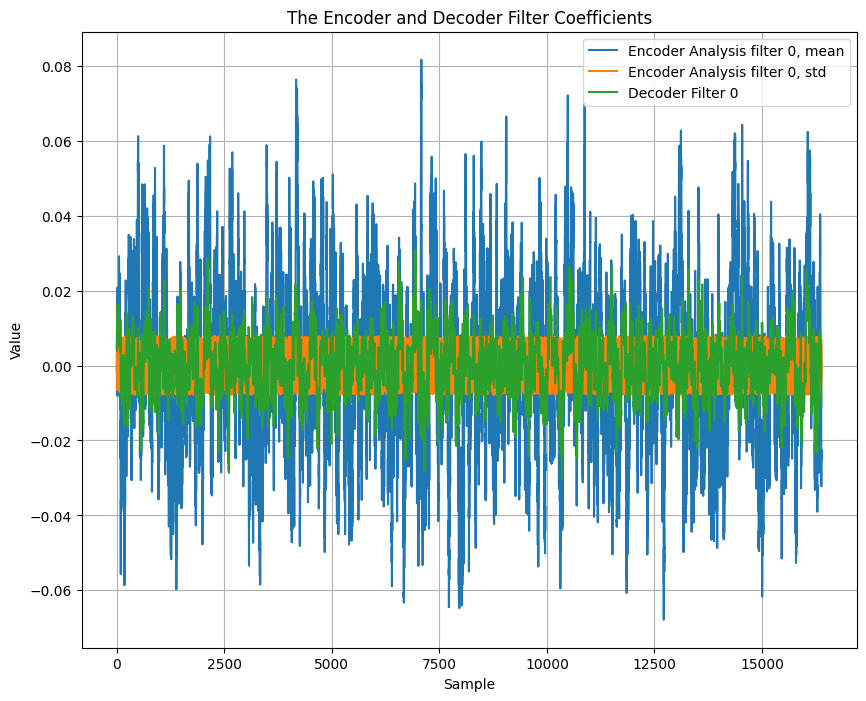

In [ ]:
print("MSE=", loss_fn(Ypred, Y).item(), "Variational Loss:", variational_loss(Yencmean, Yencstd).item())
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,8))
plt.plot(np.transpose(np.array(ww['conv1mean.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['conv1std.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['sysconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0, mean','Encoder Analysis filter 0, std', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()


In [ ]:
#Test on training set:

#predictions=model(X).cpu() # Make Predictions based on the obtained weights, on training set
#noisy case:
#predictions, Yencmean, Yencstd = model(X)
Yencmean=model.encodermean(X)

#no noise case
predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)

#Add gaussian noise with unit standard deviation to encoded signal:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions=model.decoder(Yvariational)

predictions=predictions.detach()
predictions=np.array(predictions)
Yencmean=np.array(Yencmean.detach())
Yencstd=np.array(Yencstd.detach())
print("Yencstd.shape=",Yencstd.shape)

Y=np.array(Y) #target
#print("Y=",Y)
print("predictions.shape=", predictions.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2

Yencstd.shape= (1, 32, 36)
predictions.shape= (1, 1, 286722)


In [ ]:
import IPython.display as ipd


"The training set output for clean encoded signal for batch0"


"The training set output for noisy encoded signal for batch0"


IndexError: index 1 is out of bounds for axis 0 with size 1

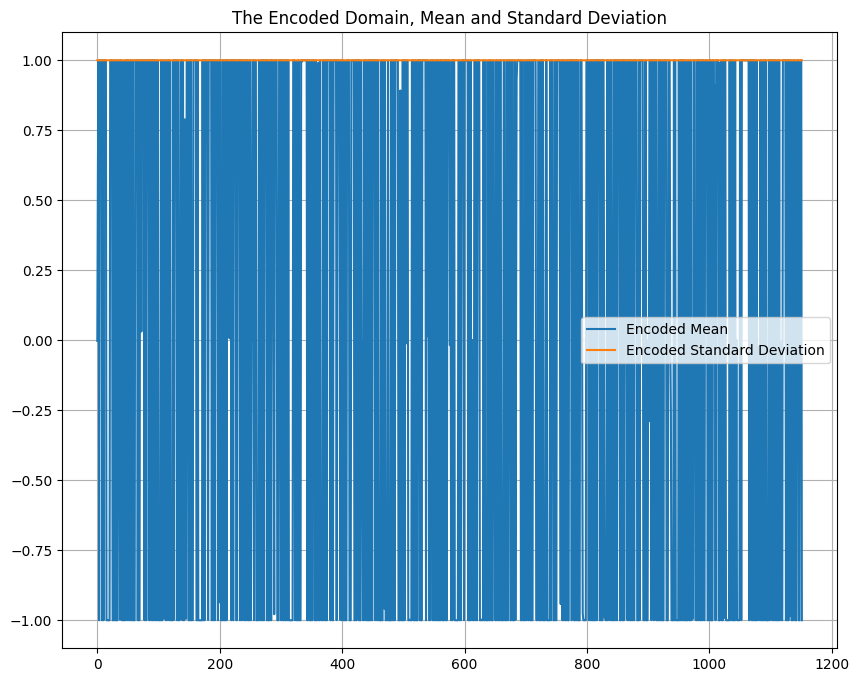

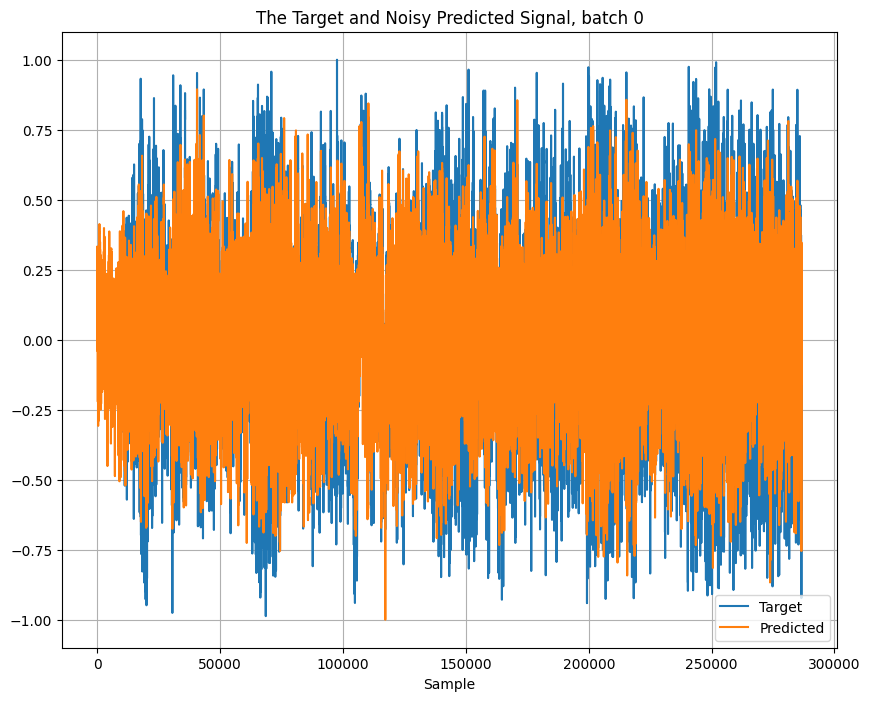

<Figure size 1000x800 with 0 Axes>

In [ ]:
#Plot target signal and output of autoencoder:

for b in range(batch):
    #print("np.reshape(Yencstd[b,:,:],(1,-1))", np.reshape(Yencstd[b,:,:],(1,-1)))
    plt.figure(figsize=(10,8))
    plt.plot(np.reshape(Yencmean[b,:,:],(1,-1))[0,:])
    plt.plot(np.reshape(Yencstd[b,:,:],(1,-1))[0,:])
    plt.legend(('Encoded Mean', 'Encoded Standard Deviation'))
    plt.title('The Encoded Domain, Mean and Standard Deviation')
    plt.grid()
    plt.figure(figsize=(10,8))
    plt.plot(np.array(Y[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Noisy Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.grid()

    #No noise case:
    xrek=predclean[b,0,:]  #remove unnecessary dimension for playback
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for clean encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))

    xrek=predictions[b,0,:]  #remove unnecessary dimension for playback
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvae'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for noisy encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))


The verification set input to the variational autoencoder


The verification set output for clean encoded signal


The verification set output for noisy encoded signal


Only noise as encoded signal
The decoded signal


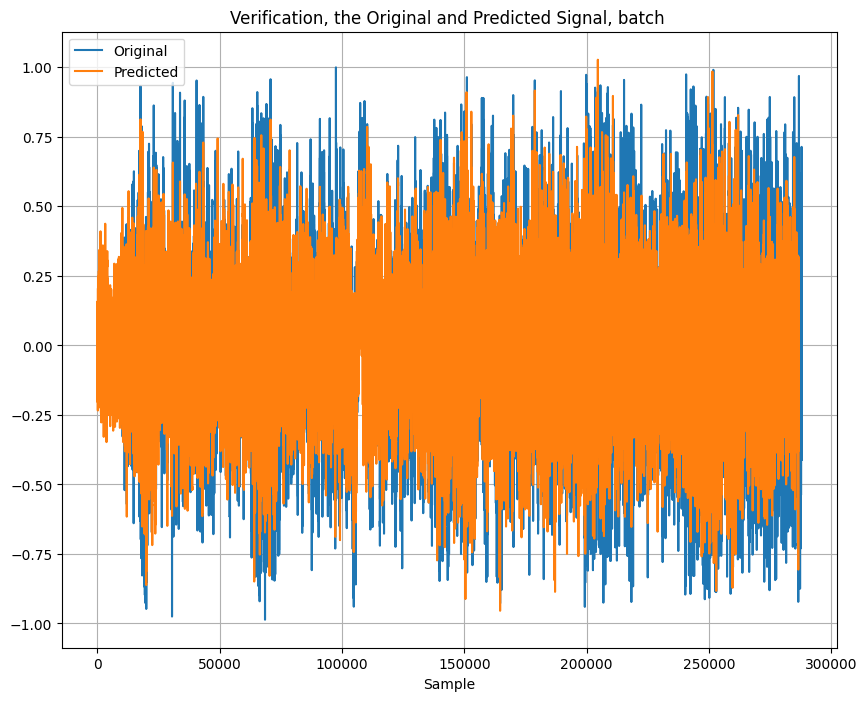

In [ ]:
#Test on Verification set:
#fs, x= wav.read('test.wav')
x, fs = librosa.load("/content/drive/MyDrive/Test Audio/voice notes 3.mp3", mono=True, sr=None, duration=6, offset=0)
#fs, x= wav.read('test2.wav')
#x=x*1.0/2**15 #normalize
x=x/max(x)

print("The verification set input to the variational autoencoder")
display(ipd.Audio(2**15*x,rate=fs))
X=signal2pytorch(x).to(device)
Yencmean=model.encodermean(X)

predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)

#No noise case:
xrek=predclean[0,0,:]  #remove unnecessary dimension for playback
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testvervaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
print("The verification set output for clean encoded signal")
display(ipd.Audio(2**15*xrek, rate=fs))

#Add gaussian noise with unit standard deviation:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
b=0
plt.figure(figsize=(10,8))
plt.plot(np.array(X[b,0,:]))
plt.plot(predictions[b,0,:])
plt.legend(('Original','Predicted'))
plt.title('Verification, the Original and Predicted Signal, batch ')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testver.wav', fs, np.int16(2**15*xrek))
print("The verification set output for noisy encoded signal")
display(ipd.Audio('testver.wav', rate=fs))
print("Only noise as encoded signal")

Yvariational=  torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('noisevarout.wav', fs, np.int16(2**15*xrek))
print("The decoded signal")
display(ipd.Audio('noisevarout.wav', rate=fs))


In [ ]:
torch.ones(Yencmean.shape)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [ ]:
#Test on Verification set:
#fs, x= wav.read('test.wav')
x, fs = librosa.load("/content/drive/MyDrive/Test Audio/Charlie Puth - That's HilariousLeft And Right (Live from NBC's The Voice 2022).mp3", mono=True, sr=None, duration=120, offset=0)
#fs, x= wav.read('test2.wav')
#x=x*1.0/2**15 #normalize
x=x/max(x)

print("The verification set input to the variational autoencoder")
display(ipd.Audio(2**15*x,rate=fs))
X=signal2pytorch(x).to(device)
Yencmean=model.encodermean(X)

predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)

#No noise case:
xrek=predclean[0,0,:]  #remove unnecessary dimension for playback
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testvervaeclean2'+str(b)+'.wav', fs, np.int16(2**15*xrek))
print("The verification set output for clean encoded signal")
display(ipd.Audio(2**15*xrek, rate=fs))

#Add gaussian noise with unit standard deviation:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
b=0
plt.figure(figsize=(10,8))
plt.plot(np.array(X[b,0,:]))
plt.plot(predictions[b,0,:])
plt.legend(('Original','Predicted'))
plt.title('Verification, the Original and Predicted Signal, batch ')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testver.wav', fs, np.int16(2**15*xrek))
print("The verification set output for noisy encoded signal")
display(ipd.Audio('testver.wav', rate=fs))
print("Only noise as encoded signal")

Yvariational=  torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('noisevarout.wav', fs, np.int16(2**15*xrek))
print("The decoded signal")
display(ipd.Audio('noisevarout2.wav', rate=fs))


The verification set input to the variational autoencoder


The verification set output for clean encoded signal


The verification set output for noisy encoded signal


Only noise as encoded signal
The decoded signal


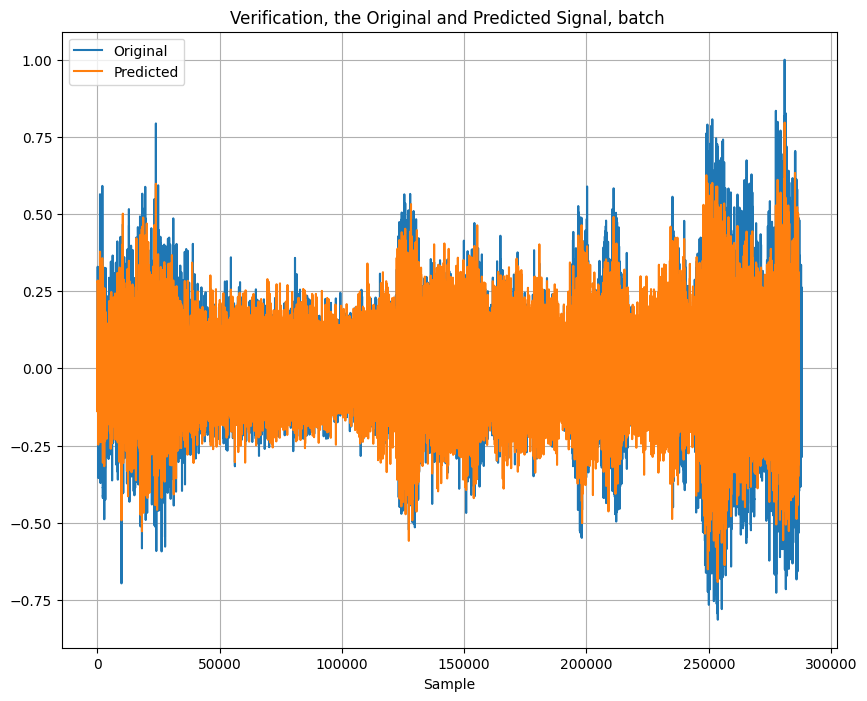

In [ ]:
#Test on Verification set:
#fs, x= wav.read('test.wav')
x, fs = librosa.load("/content/drive/MyDrive/Test Audio/Charlie Puth - Attention (LIVE) 4K.mp3", mono=True, sr=None, duration=6, offset=0)
#fs, x= wav.read('test2.wav')
#x=x*1.0/2**15 #normalize
x=x/max(x)

print("The verification set input to the variational autoencoder")
display(ipd.Audio(2**15*x,rate=fs))
X=signal2pytorch(x).to(device)
Yencmean=model.encodermean(X)

predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)

#No noise case:
xrek=predclean[0,0,:]  #remove unnecessary dimension for playback
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testvervaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
print("The verification set output for clean encoded signal")
display(ipd.Audio(2**15*xrek, rate=fs))

#Add gaussian noise with unit standard deviation:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
b=0
plt.figure(figsize=(10,8))
plt.plot(np.array(X[b,0,:]))
plt.plot(predictions[b,0,:])
plt.legend(('Original','Predicted'))
plt.title('Verification, the Original and Predicted Signal, batch ')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testver.wav', fs, np.int16(2**15*xrek))
print("The verification set output for noisy encoded signal")
display(ipd.Audio('testver.wav', rate=fs))
print("Only noise as encoded signal")

Yvariational=  torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('noisevarout.wav', fs, np.int16(2**15*xrek))
print("The decoded signal")
display(ipd.Audio('noisevarout.wav', rate=fs))
